# FRLC Demo notebook

_Factor relaxation with latent coupling_ (abbreviated FRLC with the mnemonic "frolic") solves for a rank $r$ optimal transport coupling $\mathbf{P} \in \Pi_{r}(\mathbf{a}, \mathbf{b})$ which aligns a distribution $\mathbf{a}$ to a distribution $\mathbf{b}$ with least Wasserstein cost

$$\mathbf{P}^{*} = \arg\min_{\mathbf{P} \in \Pi_{r}(\mathbf{a}, \mathbf{b})} \langle \mathbf{C}, \mathbf{P} \rangle_{F} $$

by returning a factorization of $\mathbf{P}$ in terms of two sub-couplings $\mathbf{Q}, \mathbf{R}$ and a latent coupling $\mathbf{T}$ $$\mathbf{P} = \mathbf{Q} \mathrm{diag}(1 / \mathbf{g}_{Q}) \mathbf{T} \mathrm{diag}(1 / \mathbf{g}_{R}) \mathbf{R}^{T} $$
where one can imagine this coarsening the full transport $(\mathbf{P}, \mathbf{a}, \mathbf{b}) \mapsto (\mathbf{T}, \mathbf{g}_{Q}, \mathbf{g}_{R})$ from being over the observed datapoints to $r$ latent clusters. The latent coupling, importantly, can be non-diagonal and represent hidden non-square transitions in the transport. In this simple demo notebook, we demonstrate how to use FRLC and visualize interpretable outputs from it.

In [1]:
# Packages for generating example datasets
import numpy as np
import torch
import torchdyn
from torchdyn.datasets import generate_moons
from scipy.spatial import distance
import matplotlib.pyplot as plt
# Import FRLC packages
import FRLC
import util
import plotting

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

# 2-Moons and 8-Gaussians

We evaluate use the simple synthetic dataset of:
https://github.com/atong01/conditional-flow-matching/blob/main/examples/2D_tutorials/tutorial_training_8_gaussians_to_moons.ipynb. The alignment task for this dataset concerns aligning two-moons with 8-spatially localized 2D-Gaussian densities.

In [3]:
import math 

def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data


def sample_moons(n):
    x0, _ = generate_moons(n, noise=0.2)
    return x0 * 3 - 1

def sample_8gaussians(n):
    return eight_normal_sample(n, 2, scale=5, var=0.1).float()

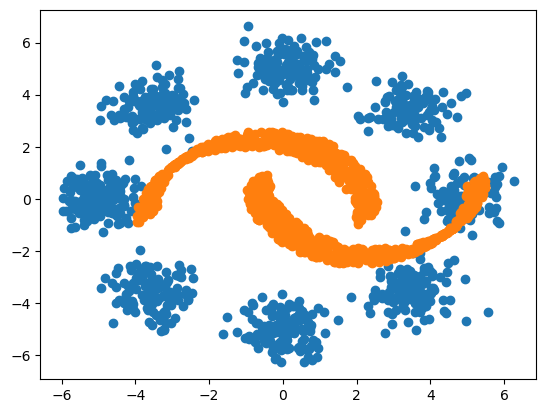

In [4]:
from ott.geometry import pointcloud, geometry

batch_size1 = 1000
batch_size2 = 1000

g1 = np.ones((batch_size1)) / batch_size1
g2 = np.ones((batch_size2)) / batch_size2

x0 = sample_8gaussians(batch_size1)
x1 = sample_moons(batch_size2)

plt.scatter(x0[:,0], x0[:,1])
plt.scatter(x1[:,0], x1[:,1])
plt.show()

C = torch.from_numpy(distance.cdist(x0, x1)).to(device)
# We recommended normalizing input distance matrices by the max-value for numerical stability and may make this a default.
C = C / C.max()

To run the method, simply call <tt>` FRLC.FRLC_opt `</tt> on the distance matrices used (e.g. $\mathbf{C}$ for the Wasserstein problem, $\mathbf{A}, \mathbf{B}$ for GW or in addition to $\mathbf{C}$ for FGW). You can toggle the type of optimization with the flag <tt>`Wasserstein=True`</tt> or <tt>`Wasserstein=False`</tt> and <tt>`FGW=True`</tt>. Additional flags <tt>`semiRelaxedLeft=True`</tt>, <tt>`semiRelaxedRight=True`</tt>, or <tt>`semiRelaxedRight=True`</tt> can be set to pick between standard relaxed OT problems. If all flags are False (default), then the OT run is balanced.

By default, we assume that the return is in the form $(\mathbf{Q}, \mathbf{R}, \mathbf{T})$ where one has access to the latent coupling $\mathbf{T}$ and the sub-couplings $\mathbf{Q}$ and $\mathbf{R}$ which map from the observed points to the latent points. Setting <tt>` returnFull = True `</tt> will return the full low-rank alignment matrix $\mathbf{P}$ instead.

Iteration: 0


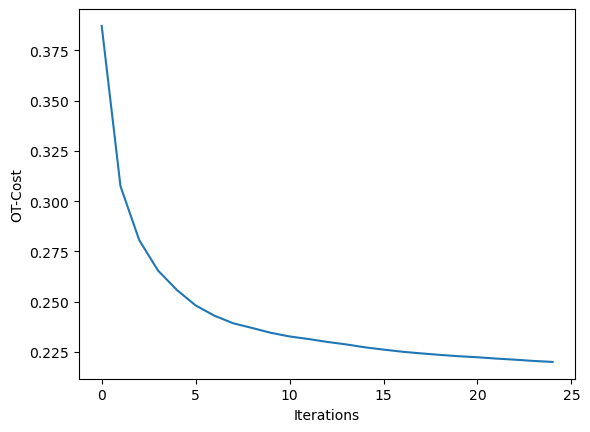

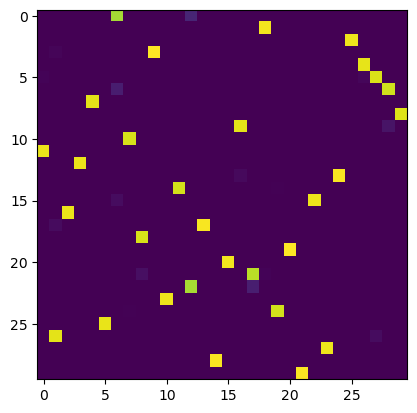

OT cost of FRLC: 0.2199909395501556


In [5]:
Q,R,T, errs = FRLC.FRLC_opt(C, device=device, r=30, r2=30, max_iter=100)

print(f'OT cost of FRLC: {errs[-1].item()}')

Q,R,T = Q.cpu(),R.cpu(),T.cpu()
_x0, _x1 = x0.double(), x1.double()

Q_barycenters, R_barycenters = util.LC_proj(_x0, _x1, Q, R)

/home/ph3641/FRLC/FRLC/plotting.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([bary_source[i,0], bary_target[j,0]],


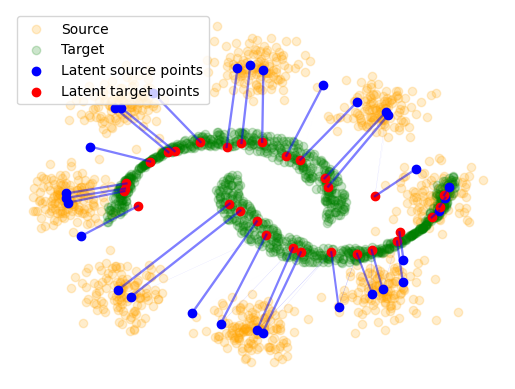

In [6]:
plotting.plot_pts(_x0, _x1, Q_barycenters, R_barycenters, T, scale=50, file_handle="twomoons_LC_proj.svg") # , file_handle="twomoons_LC_proj.svg"

# Diagonalized output
To be consistent with the factorization of other works, we can easily diagonalize the output of FRLC to be in the form $\mathbf{P} = \mathbf{Q} \mathrm{diag}(1/ \mathbf{g}) \mathbf{R}^{T}$. In this case, we return $\mathbf{T} = \mathrm{diag}(\mathbf{g})$ and appropriately scale the sub-coupling to reflect this diagonalization.

Iteration: 0


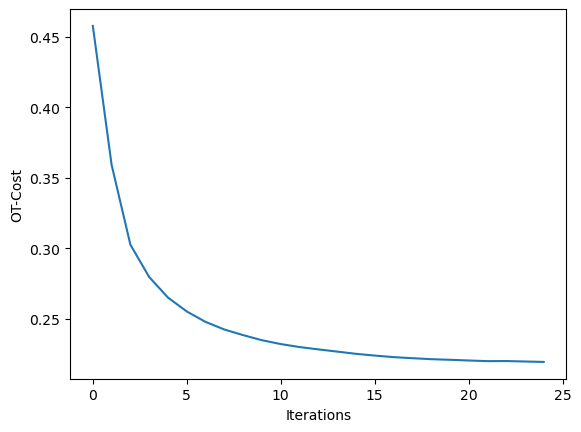

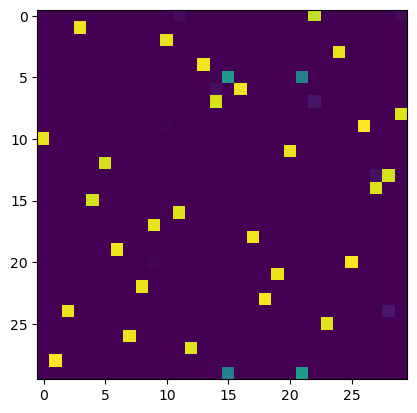

OT cost of ours
tensor(0.2197, dtype=torch.float64)


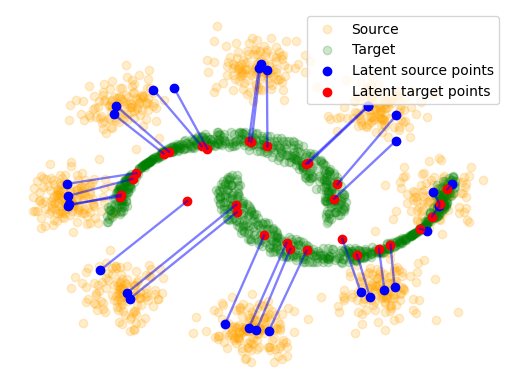

In [7]:
import util

Q,R,T, errs = FRLC.FRLC_opt(C, device=device, r=30, r2=30, \
                               max_iter=100, diagonalize_return=True)

print('OT cost of ours')
print(errs[-1])

Q_barycenters, R_barycenters = util.LC_proj(_x0, _x1, Q, R)
plotting.plot_pts(_x0, _x1, Q_barycenters, R_barycenters, T, scale=50, file_handle="twomoons_LC_proj.svg")


# Low-rank distance matrix version

We also offer a variant of FRLC (<tt>` FRLC.FRLC_LR_opt `</tt>) which supposes the distance matrices $\mathbf{C}, \mathbf{A}, \mathbf{B}$ are each factored as:

$$\mathbf{C} = \mathbf{C}_{1} \mathbf{C}_{2}^{T}$$
$$\mathbf{A} = \mathbf{A}_{1} \mathbf{A}_{2}^{T}$$
$$\mathbf{B} = \mathbf{B}_{1} \mathbf{B}_{2}^{T}$$

If a user wants to compute these factorizations from their data-points, we offer the approximation algorithm of (Indyk et al 2019) to do so -- in their algorithm $\epsilon$ is a parameter controlling the additive approximation error and the number of iterations scales as $\mathrm{poly}(1/\epsilon)$ so we recommend not setting it too low. We note that while <tt>` FRLC.FRLC_LR_opt `</tt> implements the full FGW and recovers Wasserstein or GW as an edge case of $\alpha = 0$ or $\alpha = 1$, it only performs balanced OT currently. This will be amended in future updates, and we otherwise recommend users try <tt>` FRLC.FRLC_opt `</tt> instead.

In [8]:
C1, C2 = util.low_rank_distance_factorization(_x0, _x1, r=60, eps=0.02, device=device, dtype=torch.float64)
A1, A2 = util.low_rank_distance_factorization(_x0, _x0, r=60, eps=0.02, device=device, dtype=torch.float64)
B1, B2 = util.low_rank_distance_factorization(_x0, _x0, r=60, eps=0.02, device=device, dtype=torch.float64)

# Normalize by max value
c = (C1 @ C2).max()**1/2
C1, C2 = C1/c, C2/c

C_factors, A_factors, B_factors = (C1, C2), (A1, A2), (B1, B2)

Iteration: 0
Initial Wasserstein cost: 0.06974058240739232, GW-cost: 21.703604215761708, Total cost: 0.06974058240739232
Final Wasserstein cost: 0.036635525362478084, GW-cost: 21.662497455015547, Total cost: 0.036635525362478084


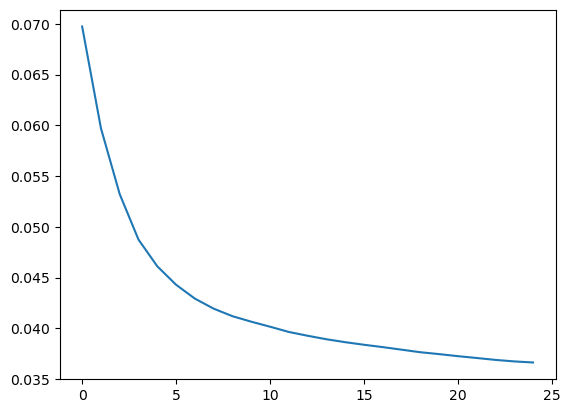

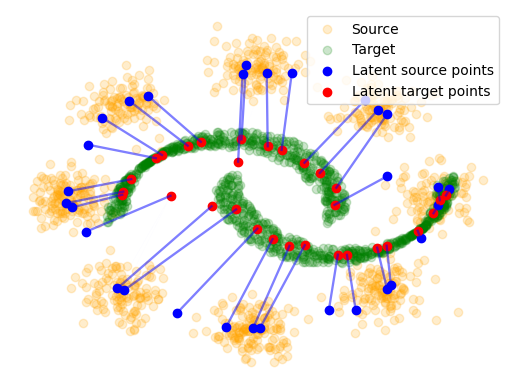

In [9]:
import importlib
import objective_grad
importlib.reload(FRLC)
importlib.reload(objective_grad)

Q, R, T, errs = FRLC.FRLC_LR_opt(C_factors, A_factors, B_factors, device=device, r=30, r2=30, \
                               max_iter=100)

Q_barycenters, R_barycenters = util.LC_proj(_x0, _x1, Q, R)
plotting.plot_pts(_x0, _x1, Q_barycenters, R_barycenters, T, scale=50, file_handle="twomoons_LC_proj.svg")
